In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FIRLowPassFilter(nn.Module):
    def __init__(self, fc: float, fs: float, filter_order: int = 64):
        """
        Initialize the FIR low-pass filter.

        Args:
            fc (float): Cutoff frequency in Hz.
            fs (float): Sampling frequency in Hz.
            filter_order (int): Number of filter taps (order).
        """
        super(FIRLowPassFilter, self).__init__()
        self.fc = fc
        self.fs = fs
        self.filter_order = filter_order
        self.filter_weights = self.create_fir_filter(fc, fs, filter_order)
        self.padding = filter_order // 2

    def create_fir_filter(self, fc: float, fs: float, filter_order: int):
        """
        Create FIR filter coefficients using the Hamming window method.

        Args:
            fc (float): Cutoff frequency in Hz.
            fs (float): Sampling frequency in Hz.
            filter_order (int): Number of filter taps (order).
        Returns:
            torch.Tensor: FIR filter coefficients.
        """
        # Normalize the cutoff frequency
        fc_norm = fc / (fs / 2)  # Normalized to Nyquist frequency

        # Generate the filter taps using a Hamming window
        n = torch.arange(filter_order)
        hamming_window = 0.54 - 0.46 * torch.cos(2 * torch.pi * n / (filter_order - 1))
        sinc_filter = torch.sinc(2 * fc_norm * (n - (filter_order - 1) / 2))
        fir_coeffs = sinc_filter * hamming_window
        fir_coeffs /= fir_coeffs.sum()  # Normalize

        # Convert to a 3D tensor for convolution (input_dim as channel)
        fir_coeffs = fir_coeffs.view(1, 1, -1)
        return fir_coeffs

    def forward(self, x: torch.Tensor):
        """
        Apply the FIR low-pass filter using convolution.

        Args:
            x (torch.Tensor): Input signal of shape (src_len, batch_size, input_dim).
        Returns:
            torch.Tensor: Filtered signal of the same shape.
        """
        src_len, batch_size, input_dim = x.shape
        
        # Transpose for convolutional compatibility
        x = x.permute(1, 2, 0)  # (batch_size, input_dim, src_len)
        
        # Expand the filter to match the input dimensions
        fir_filter = self.filter_weights.to(x.device).expand(input_dim, 1, self.filter_order)

        # Apply convolution using the FIR filter (depthwise)
        y = F.conv1d(
            x, 
            fir_filter, 
            padding=self.padding, 
            groups=input_dim
        )

        # Transpose back to original shape
        y = y.permute(2, 0, 1)  # (src_len, batch_size, input_dim)
        return y


torch.Size([501, 8, 16])


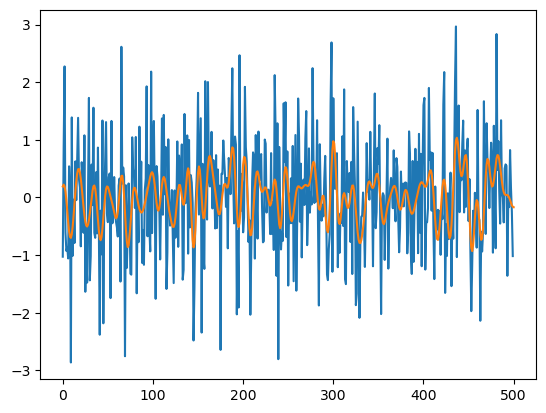

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

# Example Usage
fs = 1000  # Sampling frequency (Hz)
fc = 50    # Cutoff frequency (Hz)
filter_order = 64  # FIR filter order
filter = FIRLowPassFilter(fc, fs, filter_order)

# Sample input signal: (src_len, batch_size, input_dim)
x = torch.randn(500, 8, 16)  # (src_len=500, batch_size=8, input_dim=16)

# Apply the filter
y = filter(x)

print(y.shape)  # Output should be (500, 8, 16)

xNp = x.cpu().detach().numpy()
yNp = y.cpu().detach().numpy()
plt.plot(xNp[:,0,1])
plt.plot(yNp[:,0,1])